# Analiza Danych #4. Lokalizowanie kontynentów na podstawie położenia Starbucksów na mapie świata

### Poprzednie wpisy z serii Analiza Danych dotyczyły nadzorowanych algorytmów uczenia maszynowego. Ta grupa wykorzystuje następującą zasadę – dzielimy zbiór danych na część uczącą i testową, następnie wykorzystując dane uczące tworzymy odpowiedni model statystyczny który później ewaluujemy za pomocą danych testowych. Idea ta jest bardzo prosta i daje łatwą możliwość sprawdzenia na ile stworzony przez nas model jest wiarygodny. Nie zawsze jednak w przypadku uczenia maszynowego mamy taką możliwość. Istnieją również algorytmy, które nie umożliwiają tego typu weryfikacji. Nie zawsze jest ona zresztą konieczna – czasami predykcja przez nas czyniona, albo podział danych na kategorie jest raczej umowny niż ściśle określony. Jednym z najbardziej popularnych algorytmów tego typu jest *K Means Clustering* polegający na automatycznym dzieleniu danych na pewne grupy, klastry które mogą być interpretowane na przykład jako kategorie. Można więc traktować *K Means Clustering* jako nienadzorowany odpowiednik algorytmów kategoryzujących – KNN czy SVM.

Zanim przejdę do przedstawienia tego co zapowiedziałem w tytule zacznę od dokładniejszego omówienia *K Means*. Tak jak wspomniałem służy on do podziału danych na kategorie. Często wtedy, kiedy podział ma być umowny i nie można z całym przekonaniem powiedzieć, że te konkretne dane rzeczywiście należą do tej kategorii. Na przykład – jeżeli w jakimś mieście często dochodzi do przestępstw ale z pewnych przyczyn ich lokalizacje nie są rozłożone równomiernie i można zaobserwować skupiska gdzie tych przestępstw jest więcej to dobrym pomysłem wydaje się być rozmieszczenie komisariatów policji nie w przypadkowych miejscach tylko właśnie w centrach tych skupisk co oczywiście pomoże zminimalizować średni czas interwencji. Ten przykład, choć dosyć uproszczony, dobrze pokazuje pewną ideę która kryje się w metodzie *K Means* – wyodrębnione kategorie wcale nie muszą zostać w żaden sposób zlabelowane. Nie chodzi tutaj o przyporządkowanie rekordów w bazie danych albo punktów na mapie do jakiejś konkretnej kategorii tylko o stworzenie kilku klastrów które będzie można później traktować jako na swój sposób oddzielne byty.

   Pomimo tego, że *K Means jest metodą nienadzorowaną to można poddać ją testowaniu stosując prosty trik – wystarczy podać do niej zlabelowane dane, takie jakie możnaby wykorzystać w K Nearest Neighbors. Dałoby się wtedy porównać rezultat działania algorytmu i przydział danych do kategorii (które znamy).  W rzeczywistych przypadkach jednak taka sztuczka nie będzie możliwe bo z góry nie wiemy do jakich klastrów należą które dane.

  Działanie K Means można zobrazować w prosty sposób posługując się sztucznie wygenerowanymi danymi. Podobnie jak przy KNN i SVM dane te powinny mieć dwie zmienne niezależne, tak żeby dało się pokazać je na wykresie 2D. Do generowania sztucznych danych na potrzeby klastrowania istnieją odpowiednie biblioteki (kod jak zwykle na GitHubie). Rezultat jest następujący:

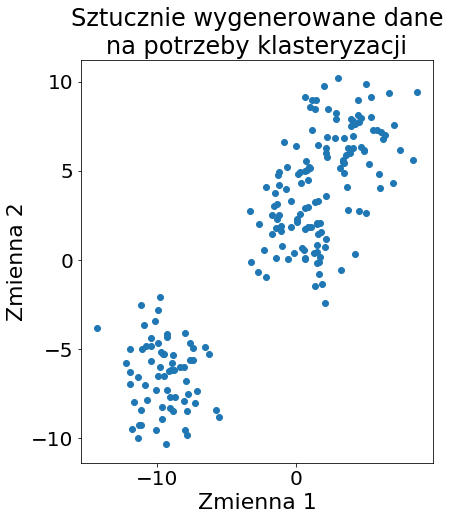

In [4]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

data = make_blobs(n_samples = 200, n_features = 2, centers = 3, cluster_std = 1.8, random_state = 101)

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
plt.scatter(data[0][:,0], data[0][:,1])
plt.xlabel('Zmienna 1', fontsize = 22)
plt.ylabel('Zmienna 2', fontsize = 22)
plt.title('Sztucznie wygenerowane dane\nna potrzeby klasteryzacji', fontsize = 24)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.subplots_adjust(left = 0.2, bottom = 0.1, right = 0.9, top = 0.9)



a tak wyglądają te punkty pokolorowane według klastra, w którym zostały wygenerowane:

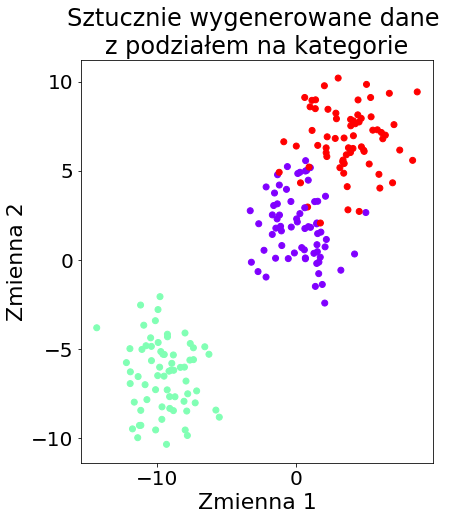

In [6]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
plt.scatter(data[0][:,0], data[0][:,1], c = data[1], cmap = 'rainbow')
plt.xlabel('Zmienna 1', fontsize = 22)
plt.ylabel('Zmienna 2', fontsize = 22)
plt.title('Sztucznie wygenerowane dane \nz podziałem na kategorie', fontsize = 24)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.subplots_adjust(left = 0.2, bottom = 0.1, right = 0.9, top = 0.9)


Następnie zestaw punktów został podany do K Meansa, który nie znając ich kategorii (a jedynie położenie w przestrzeni 2D) dokonał podziału na 3 grupy. Co istotne, algorytm posiada parametr określający liczbę klastrów i musi on zostać podany podczas implementacji. Poniższy wykres przedstawia porównanie przyporządkowania zgodnie z oryginalnym podziałem oraz według algorytmu. Łatwo zauważyć, że podczas generacji losowych punktów część z nich się nawzajem wymieszała, ale K Means – nie wiedząc o tym – tak podzielił punkty, żeby dwa zbiory się na siebie nie nakładały.

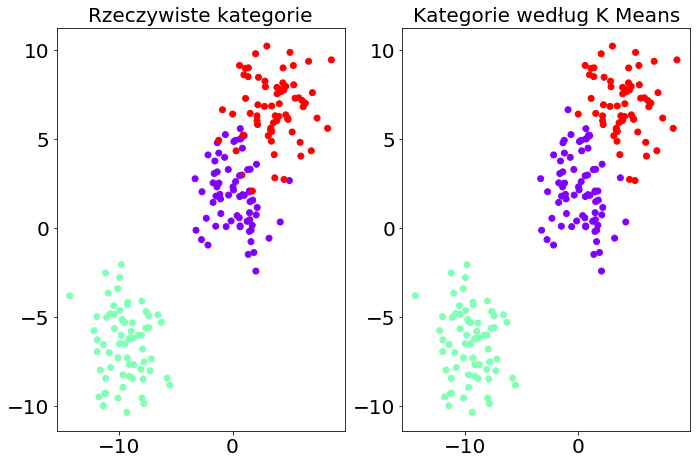

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3)
kmeans.fit(data[0])

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (11,7))
ax1.set_title('Rzeczywiste kategorie', fontsize = 20)
ax1.scatter(data[0][:,0], data[0][:,1], c = data[1], cmap = 'rainbow')
ax2.set_title('Kategorie według K Means', fontsize = 20)
ax2.scatter(data[0][:,0], data[0][:,1], c = kmeans.labels_, cmap = 'rainbow')
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.9, top = 0.9)


## Zasada działania

Zasada działania tego algorytmu jest bardzo prosta. Procedura jest następująca:

Określ wartość parametru K
Każdemu punktowi losowo przypisz numer kategorii z przedziału [1, K] (albo [0, K-1])
Powtarzaj do uzyskania zbieżności:

 – Dla każdej kategorii wyznacz położenie jej centroidy czyli punktu o każdej współrzędnej równej średniej arytmetycznej wszystkich punktów danej kategorii

 – Każdemu punktowi na nowo przypisz numer kategorii który jest taki sam jak numer najbliżej niego położonej centroidy

I to wszystko. Punkt 3. jest powtarzany tak długo aż kategorie wszystkich punktów przestaną się zmieniać. Dla lepszego pobudzenia wyobraźni przedstawiam prosty przykład dla kilku punktów o dwóch cechach i podzielonych na dwie kategorie (K = 2).

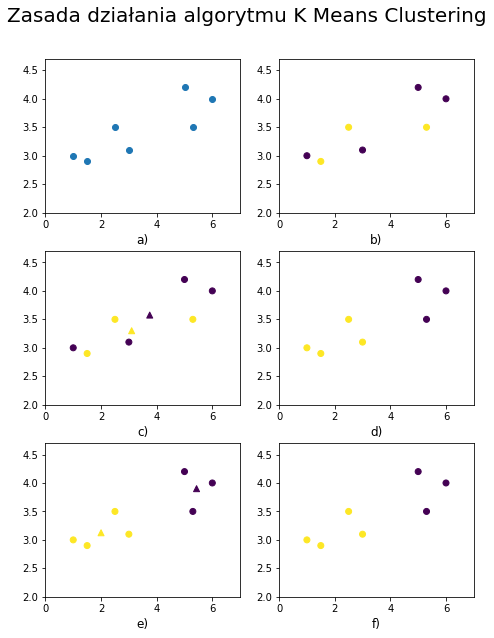

In [11]:
import numpy as np

x = [1, 1.5, 2.5, 3, 5, 5.3, 6]
y = [3, 2.9, 3.5, 3.1, 4.2, 3.5, 4]
init_kat = [1,2,2,1,1,2,1]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize = (7,9))
plt.suptitle('Zasada działania algorytmu K Means Clustering', fontsize = 20)

ax1.scatter(x, y)
ax1.set_xlabel('a)', fontdict = {'size':12})
ax1.set_xlim([0, 7])
ax1.set_ylim([2, 4.7])

ax2.scatter(x, y, c = init_kat)
ax2.set_xlabel('b)', fontdict = {'size':12})
ax2.set_xlim([0, 7])
ax2.set_ylim([2, 4.7])

ax3.scatter(x, y, c = init_kat)
ax3.set_xlabel('c)', fontdict = {'size':12})
ax3.scatter([ np.mean([i for c,i in enumerate(x) if init_kat[c]==1]), \
    np.mean([i for c,i in enumerate(x) if init_kat[c]==2])], \
    [np.mean([i for c,i in enumerate(y) if init_kat[c]==1]), \
    np.mean([i for c,i in enumerate(y) if init_kat[c]==2])], marker = '^', c = [1,2])
ax3.set_xlim([0, 7])
ax3.set_ylim([2, 4.7])

ax4.scatter(x,y, c = [2,2,2,2,1,1,1])
ax4.set_xlabel('d)', fontdict = {'size':12})
ax4.set_xlim([0, 7])
ax4.set_ylim([2, 4.7])

ax5.scatter(x,y, c = [2,2,2,2,1,1,1])
ax5.set_xlabel('e)', fontdict = {'size':12})
ax5.scatter([ np.mean(x[:4]), np.mean(x[4:]) ], [np.mean(y[:4]), np.mean(y[4:])], marker = '^', c = [2,1])
ax5.set_xlim([0, 7])
ax5.set_ylim([2, 4.7])

ax6.scatter(x,y, c = [2,2,2,2,1,1,1])
ax6.set_xlabel('f)', fontdict = {'size':12})
ax6.set_xlim([0, 7])
ax6.set_ylim([2, 4.7])

plt.subplots_adjust(left = 0.1, bottom = 0.07, right = 0.95, top = 0.9, hspace = 0.25, wspace = 0.2)


a) Zaczynamy od zestawu kilku punktów, które chcemy pogrupować na dwa klastry

b) Przyporządkowujemy je losowo do tych klastrów

c) Dla każdego klastra wyznaczamy jego centroidę (trójkąt w odpowiednim kolorze)

d) Przyporządkowujemy punkty do odpowiedniego klastra bazując na położeniu najbliższej im centroidy

e) Znowu wyznaczamy położenie centroid

(powtarzamy d) i e) tak długo aż kolejne iteracje przestaną przynosić zmiany w przyporządkowaniu punktów do klastrów)

f) Zbieżność została osiągnięta

## Próba wyodrębnienia kontynentów

 Ciekawym zastosowaniem *K Meansa* wydaje się być wykorzystanie go do danych dotyczących lokalizacji pewnych punktów co pozwoliłoby znaleźć skupiska tych punktów, w tym również centra owych skupisk. Na podobnej zasadzie jak w przykładzie z policją, o którym pisałem na początku. Znalazłem dane, które mogą się do tego całkiem nieźle nadać – zawierają one informacje na temat położenia (długość i szerokość geograficzna) kawiarni Starbucks rozsianych po całym świecie. Siłą rzeczy są one skupione na pewnych obszarach ziemi, mianowicie na terenach lądowych. O ile jednak Ameryka Północna jest nimi gęsto i dość równomiernie zapełniona, to w przypadku takich kontynentów jak Azja sprawa nie jest już taka prosta. Dataset pochodzi z serwisu kaggle.com. Ciężko niestety powiedzieć na ile jest on wiarygodny, tym bardziej że widać pewne rozbieżności między nim a artykułem o Starbucksie na Wikipedii. Tak czy inaczej nie ma to wielkiego znaczenia. Rozkład Starbucksów na świecie wygląda więc mniej więcej tak:

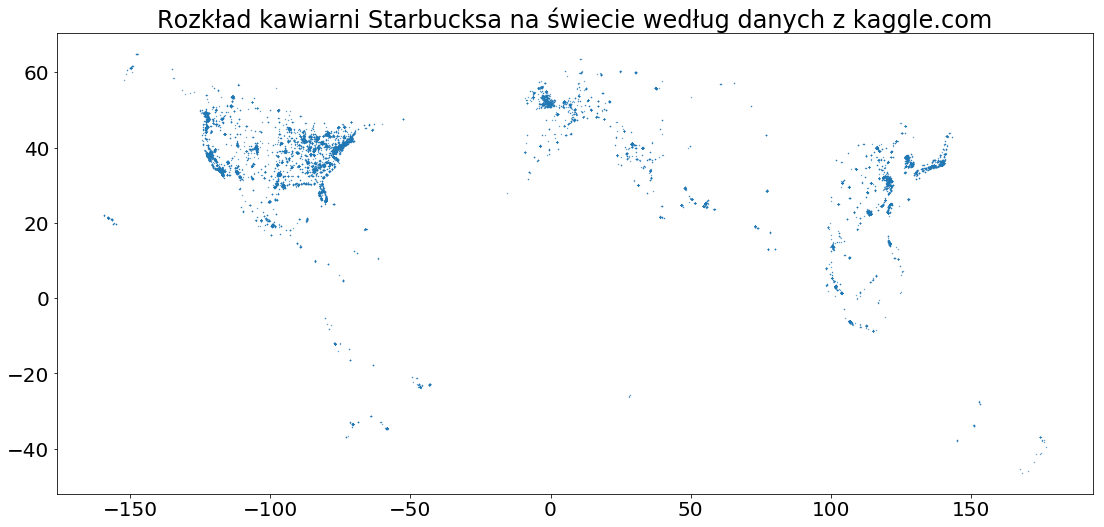

In [13]:
import pandas as pd

df = pd.read_csv('data.csv')
df = df[['Longitude','Latitude', 'Country']]
df = df.dropna()

fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(111)
plt.scatter(df['Longitude'], df['Latitude'], s = 0.1)
plt.title('Rozkład kawiarni Starbucksa na świecie według danych z kaggle.com', fontsize = 24)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.subplots_adjust(left = 0.05, bottom = 0.1, right = 0.95, top = 0.9)

Wyraźnie widać na wykresie punktowym mapę świata choć niektóre jej części są dużo bardziej wyeksponowane niż pozostałe. Na pewno rzuca się w oczy brak Afryki – widać że znajdują się tam tylko pojedyncze kawiarnie (niestety wbrew innym źródłom informacji). Po bliższym przyjrzeniu się można zauważyć, że brakuje też Włoch (a Wikipedia to potwierdza). Korea Południowa natomiast wygląda jak wyspa.

 Teraz trzeba zastanowić się na ile klastrów należy podzielić te dane. Pierwsza myśl to po jednym na każdy kontynent (oprócz Antarktydy) czyli sześć. Co jednak wtedy z Afryką w której Starbucksów prawie nie ma? Może lepiej będzie ją pominąć i założyć istnienie pięciu klastrów? Na początek zobaczmy co się stanie jeśli założymy że istnieje ich sześć:

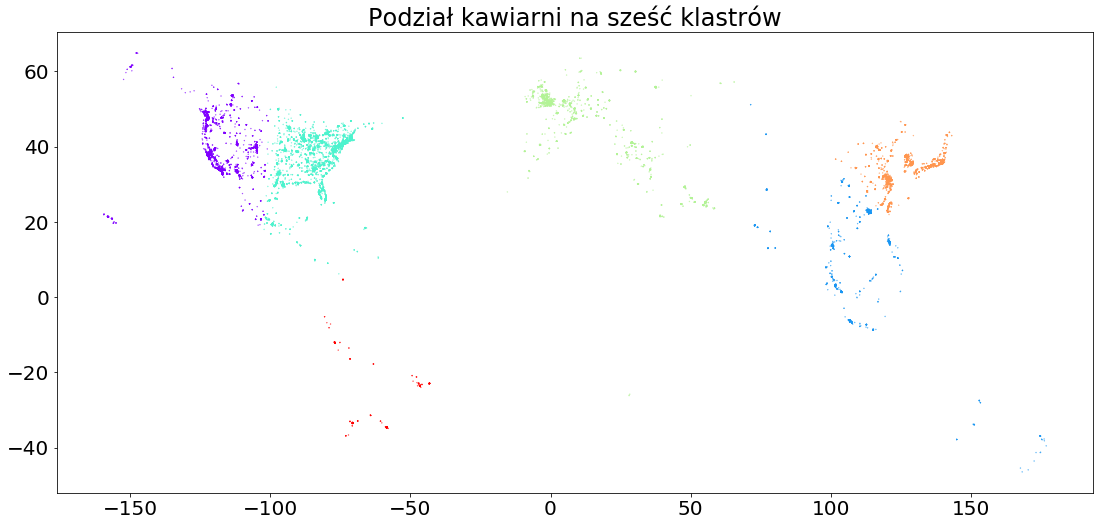

In [15]:
kmeans = KMeans(n_clusters = 6)
kmeans.fit(pd.DataFrame.as_matrix(df[['Longitude','Latitude']]))

fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(111)
plt.scatter(df['Longitude'], df['Latitude'], c = kmeans.labels_,s = 0.1, cmap = 'rainbow')
plt.title('Podział kawiarni na sześć klastrów', fontsize = 24)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.subplots_adjust(left = 0.05, bottom = 0.1, right = 0.95, top = 0.9)


Wygląda ciekawie, ale raczej nie jest to to, czego byśmy oczekiwali. Od razu rzuca się w oczy że wschodnia i zachodnia Ameryka Północna – które w skali całej ziemi są od siebie oddalone bardzo nieznacznie – zostały rozdzielone na dwie grupy. Podobnie jest w przypadku północy i południa Azji wschodniej. Pomimo tego, że patrząc na poprzedni wykres być może potraktowalibyśmy całą Ameryką jako jeden klaster, algorytm uznał że jeśli w sumie ma ich być sześć to Ameryka powinna zostać podzielona. Z kolei Australia, która pod względem odległości od Azji jest widocznie odrębna to z uwagi na małą ilość punktów w tamtym rejonie nie zdołały one “przyciągnąć” centroidy w swoją stronę. To samo dotyczy oczywiście pojedynczych punktów w Afryce. Wynikają z tego pierwsze wnioski – jeśli pewne skupisko punktów jest wyraźnie oddalone od pozostałych, ale nie jest wystarczająco liczne to nie zostanie ono uznane za osobny klaster. Jeśli z kolei pewien rejon zawiera bardzo dużo punktów ale są one skupione w dwóch różnych częściach tego rejonu to te dwie części mogą zostać uznane za oddzielne kategorie. Poniższy obrazek przedstawia podział kawiarni na kolejno 6, 5, 4 i 3 klastry:

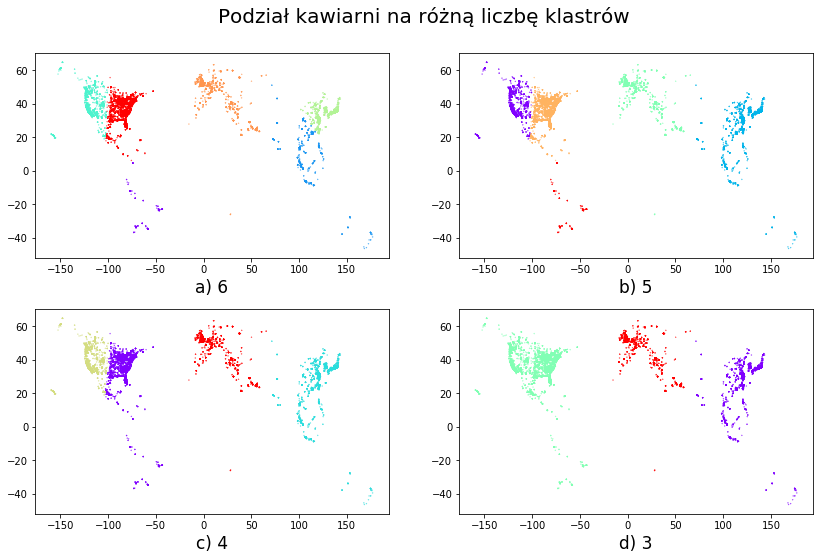

In [16]:
fig = plt.subplots(2,2,figsize = (12,8))
plt.suptitle('Podział kawiarni na różną liczbę klastrów', fontsize = 20)
axes = []
for i,n_cluster in enumerate([6,5,4,3]):
    kmeans = KMeans(n_clusters = n_cluster)
    kmeans.fit(pd.DataFrame.as_matrix(df[['Longitude','Latitude']]))

    axes.append(plt.subplot(2,2,i+1))
    plt.scatter(df['Longitude'], df['Latitude'], c = kmeans.labels_,s = 0.1, cmap = 'rainbow')
    axes[i].set_xlabel(['a) 6','b) 5','c) 4','d) 3'][i], fontdict = {'size': 17})

plt.subplots_adjust(left = 0.05, bottom = 0.1, right = 0.95, top = 0.9, hspace = 0.25)


Na koniec dodam jeszcze, że zostało wykorzystane pewne uproszczenie. Odległość mierzona według długości i szerokości geograficznej nie odpowiada rzeczywistej odległości w kilometrach. Poza tym, przy takim odwzorowaniu sfery w prostokąt odległość między np. Hawajami a Japonią jest olbrzymia podczas gdy tak naprawdę jest ona o wiele mniejsza (jeśli z Japonii będziemy kierować się na wschód). Jednak na potrzeby przedstawienia działania algorytmu zastosowana tutaj metryka jest wystarczająco odpowiednia.

## Optymalizacja ilości klastrów

Dobór wartości parametru K nie zawsze jest oczywisty. Ponieważ liczba kategorii nie jest z góry zadana to istnieje dowolność w jej wyborze. Nie każdy wybór będzie jednak równie dobry. Do znalezienia optymalnej wartości K wykorzystywana jest metoda zwana po angielsku *elbow method*. Polega ona na policzeniu odpowiednio zdefiniowanego współczynnika określającego błąd (ang. sum of squared errors, SSE) dla szeregu wartości K . Następnie te SSE powinny zostać wyplotowane a punkt największego “zgięcia” wykresu (łokieć) uznawany jest za optymalną wartość K

  W przykładzie obrazującym elbow method znowu wykorzystałem sztucznie wygenerowane dane. Przed klasteryzacją wyglądają one następująco:

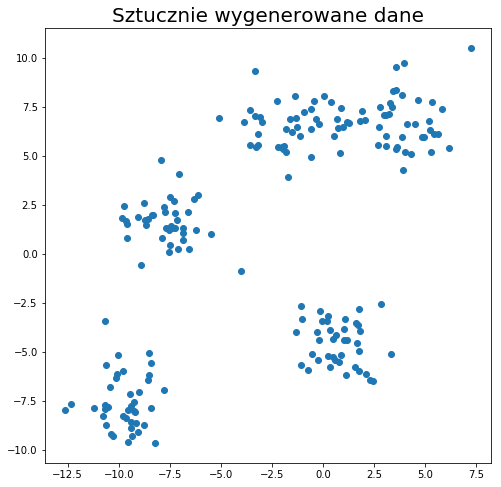

In [22]:
from scipy.spatial.distance import cdist

data = make_blobs(n_samples = 200, n_features = 2, centers = 5, cluster_std = 1.2, random_state = 100)
error = []

for K in range(3,12):
    kmeans = KMeans(n_clusters = K)
    kmeans.fit(data[0])
    error.append(sum(np.min(cdist(data[0], kmeans.cluster_centers_, 'euclidean'), axis=1)) / data[0].shape[0])

fig = plt.figure(figsize = (8,8))
plt.scatter(data[0][:,0],data[0][:,1])
plt.title('Sztucznie wygenerowane dane', fontsize = 20)
plt.show()

Natomiast wykres SSE tak:

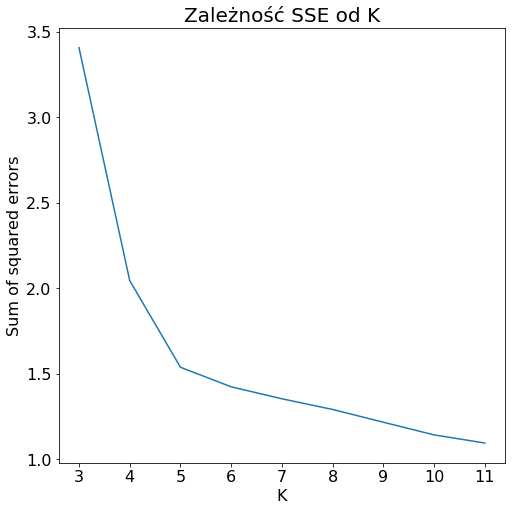

In [24]:
fig, ax = plt.subplots(1,1,figsize = (8,8))
plt.plot(range(3,12),error)
plt.xlabel('K', fontsize = 16)
plt.ylabel('Sum of squared errors', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.title('Zależność SSE od K', fontsize = 20)
plt.show()

Jak widać na wykresie, wartość argumentu dla łokcia – utożsamianego z optymalną wartością K – wynosi tutaj 5 i taka liczba klastrów powinna zostać wybrana.